In [2]:
from pathlib import Path
import pandas as pd
from src.diffusivity import (
    within_ellipsoid, 
    calculate_lsq_diffusivities, 
    within_diffusivity_envelope, 
    linear_diffusivity
    )

In [3]:
bayes_diffusivity = pd.read_csv('outputs/complete_bayes_diffusivity_results.csv')

In [4]:
# read distances
distances = pd.read_csv("data/ms_stage_distances.csv")

# run the plausible ellipsoid filter
distances["in_frac_ellipsoid"] = within_ellipsoid(
    distances[["dx_strike_m", "dy_strike_m", "dz_strike_m"]].to_numpy(),
    ellipsoid_rxryrz=(1000, 400, 600)
)

In [5]:
# calculate maximum likelihood diffusivity
freq_diffusivity = (
    distances
    .query("in_frac_ellipsoid") # the filter column
    .reset_index(drop=True)
    .groupby(["WellID", "Stage"])
    .apply(calculate_lsq_diffusivities, quantile=0.95)
    .assign(model='maximum_likelihood')
    .reset_index(drop=True)
)

# merge bayesian and frequentist frames for comparison
combined_diff_results = pd.concat([bayes_diffusivity, freq_diffusivity], axis=0)

In [12]:
# run linear diffusivity and filter events within the 97% HDI of the triggering front
bayes_filtered_distances = (distances
    .reset_index(drop=True)
    .assign(in_diff_ellipsoid = False)
    .groupby(["WellID", "Stage"])
    .apply(within_diffusivity_envelope, diffusivities=combined_diff_results, model='nonlinear')
)

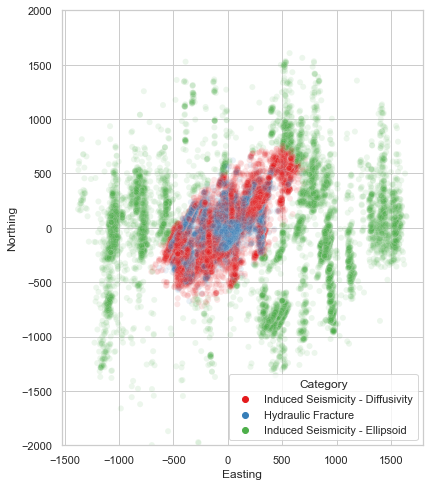

In [13]:
from src.plots import make_segregation_stage_overlay
make_segregation_stage_overlay(bayes_filtered_distances)